In [ ]:
learning_rate = 0.008

Epoch 1/10 - Loss: 0.6998 - Accuracy: 46.5714 %
Epoch 2/10 - Loss: 0.6959 - Accuracy: 50.8571 %
Epoch 3/10 - Loss: 0.6948 - Accuracy: 50.0000 %
Epoch 4/10 - Loss: 0.6938 - Accuracy: 50.7143 %
Epoch 5/10 - Loss: 0.6857 - Accuracy: 53.2857 %
Epoch 6/10 - Loss: 0.5987 - Accuracy: 59.8571 %
Epoch 7/10 - Loss: 0.5377 - Accuracy: 69.5714 %
Epoch 8/10 - Loss: 0.2938 - Accuracy: 86.8571 %
Epoch 9/10 - Loss: 0.2696 - Accuracy: 90.4286 %
Epoch 10/10 - Loss: 0.1979 - Accuracy: 94.2857 %


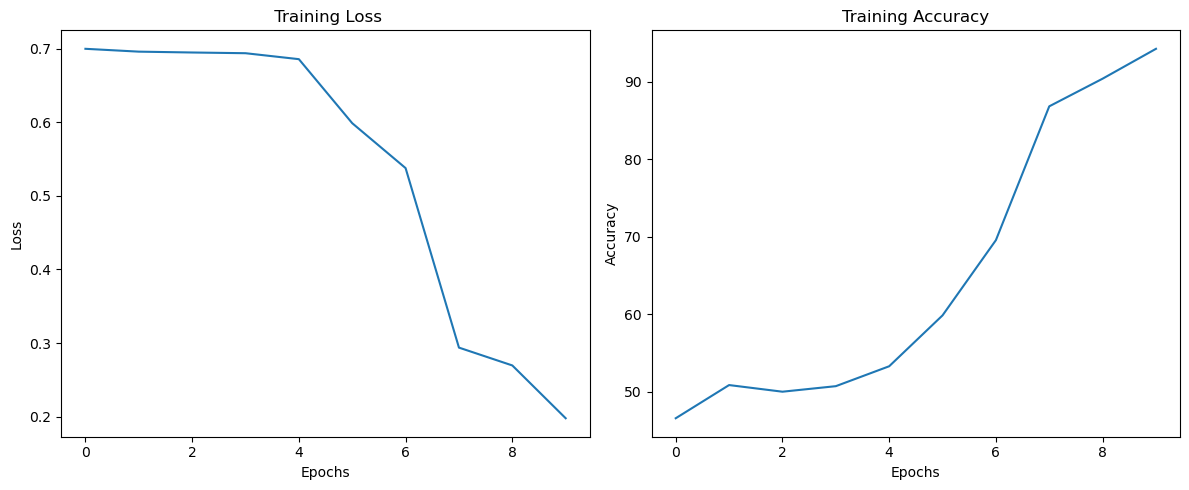

Test loss is : 0.1629 
 Accurace is : 96.33 %


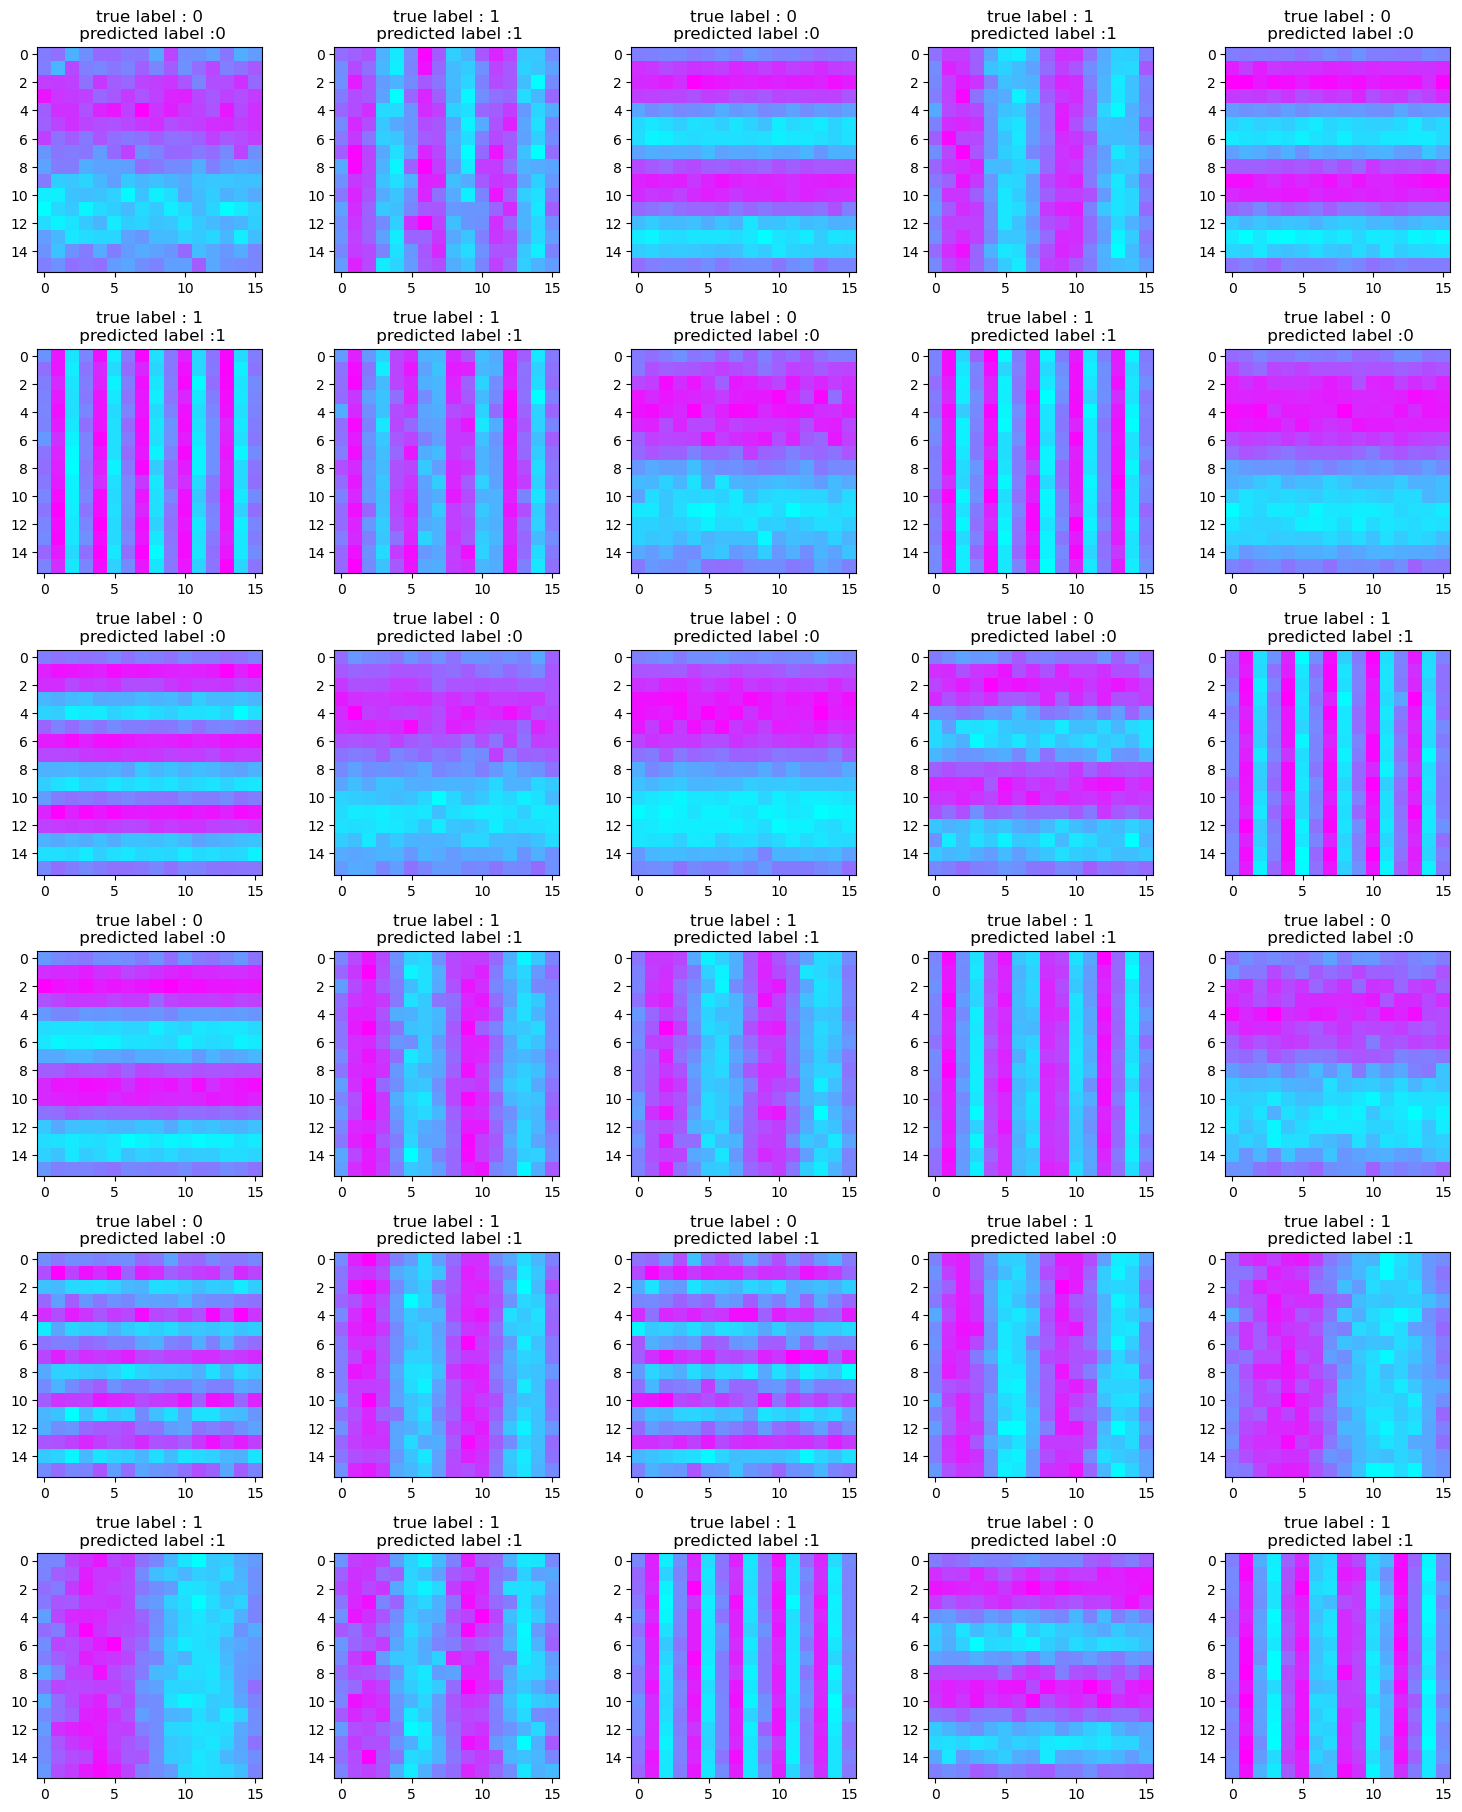

torch.Size([1, 16, 16])
torch.Size([1, 1, 16, 16])


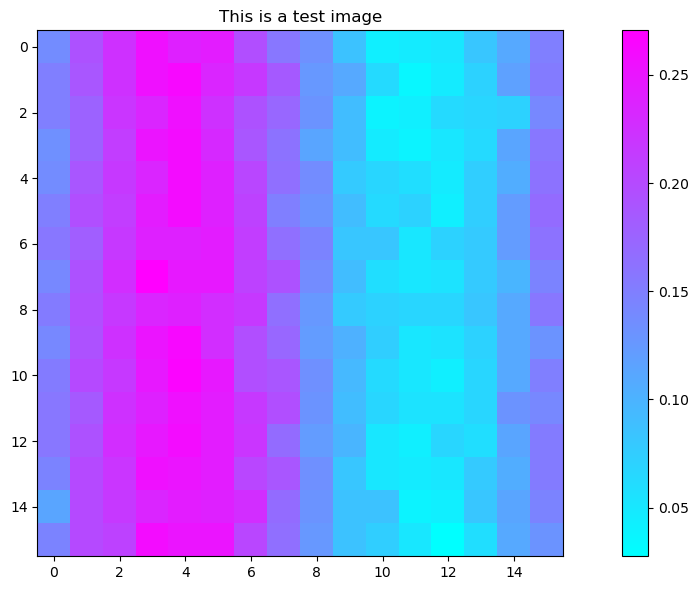

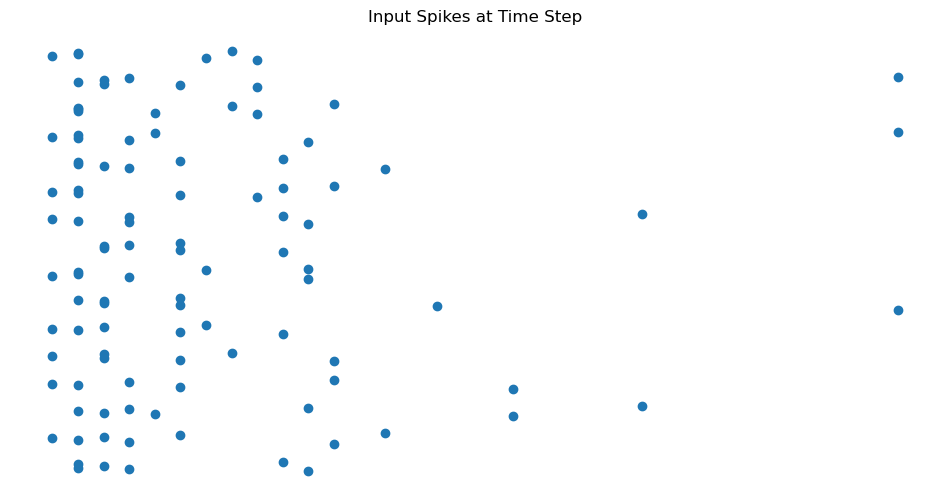

(50, 1, 2)


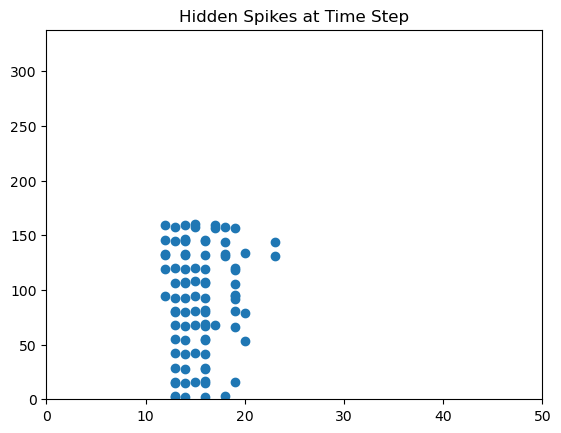

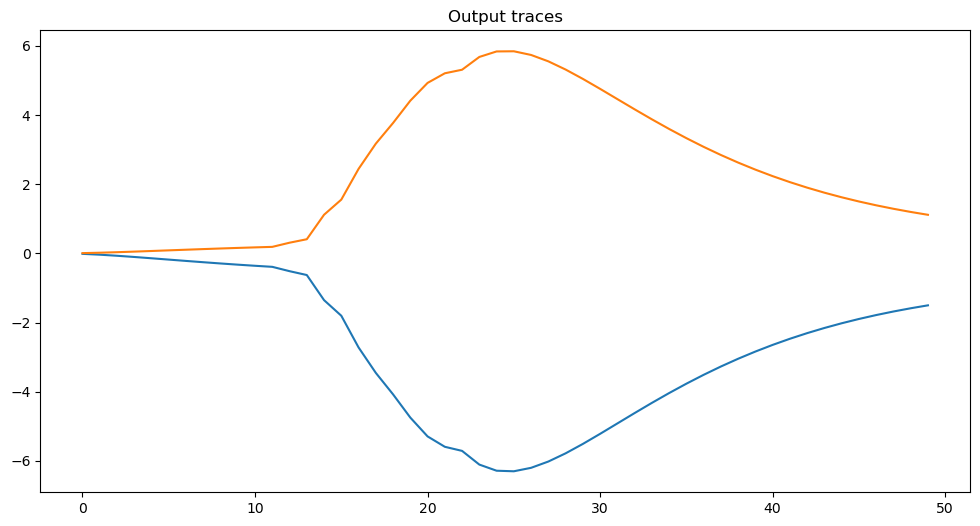

In [ ]:
import numpy as np
import norse.torch as norse
import torch
import torch.optim.adam
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from class_dataset import CustomSinDataset
import torch.utils.data.dataloader
from norse.torch.functional.encode import constant_current_lif_encode  # rate encoding
from torch.utils.data import random_split

# conv2-> lif -> maxpool2d -> 2LI layers

#! DEVICE
torch.set_printoptions(threshold=float("inf"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#! HPYERPARAPAMETERAS
input_size = 16 * 16
num_classes = 2
num_steps = 50
epochs = 10
batch_size = 20
learning_rate = 0.01
prcnt_of_train = 0.7

#!TRANSFORM
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Grayscale(),
        # transforms.Normalize((0.5,), (0.5,)),
    ]
)

dataset = CustomSinDataset(root="../custom_dataset", transform=transform)

#! SPLIT THE DATA TO TRAIN AND TEST
train_size = int(len(dataset) * prcnt_of_train)
test_size = len(dataset) - train_size
test_size
train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


#! DEFINE THE DATA LOADER

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True
)


#! MODEL
class LI2Model(nn.Module):
    def __init__(self, input_size, output_size, num_steps):
        super(LI2Model, self).__init__()

        self.num_steps = num_steps

        #!LAYERS:
        # Classic conv layer
        self.conv = nn.Conv2d(1, 2, 4, 1)
        # LIF Layer
        self.lif = norse.LIFCell(p=norse.LIFParameters())
        # Classical Pooling layer
        self.pool = nn.MaxPool2d(2, 1)
        # linear or fcl
        self.fcl = nn.Linear(288, output_size)
        # LI 1 layer
        self.li = norse.LICell(p=norse.LIParameters())

    def forward(self, x):
        batch_size = x.shape[0]  # [B,C,H,W]
        x_encoded = constant_current_lif_encode(
            x * 6, p=norse.LIFParameters(v_reset=-1000), seq_length=self.num_steps
        )

        input_spikes = x_encoded.detach().to(device)

        # print(f"This is the x_encoded {x_encoded}")
        # after the line above the x now has temporal dimension [T,B,C,H,W]
        mem_record = []
        spk_record = []
        lif_spikes_record = []
        mem = None
        mem_li = None

        for step in range(self.num_steps):
            x_curr = x_encoded[step]

            #! Going through the layers

            # conv layer
            convout = self.conv(x_curr)
            # lif layer
            spk, mem = self.lif(convout, mem)
            # pooling layer
            pooled_mem = self.pool(spk)
            # flattening
            flat = pooled_mem.view(batch_size, -1)
            # full connected layer
            lin = self.fcl(flat)
            # li layer
            out_li, mem_li = self.li(lin, mem_li)
            # store the results :
            mem_record.append(out_li)
            spk_record.append(spk)

        # the spk.shape is [20,2,13,13] with a length spk record of 50
        # out_spike_tensor = torch.stack(spk_record)
        # print(out_spike_tensor)
        # Stacked all time steps in one tensor with shape [num_steps,batch_size, num_classes]
        mem_stack = torch.stack(mem_record, dim=0)
        # print(mem_stack.shape)
        # average accross time
        final_output = torch.mean(mem_stack, dim=0)
        return final_output, spk_record, mem_record, input_spikes


#! CREATING THE MODEL
model = LI2Model(input_size=input_size, output_size=num_classes, num_steps=num_steps)

#! CREATING THE OPTIMIZER
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

#! CREATING THE CRITERION (loss)
criterion = nn.CrossEntropyLoss()

#! DEFINING THE TRAIN FUNCTION


def train(model, train_loader, optimizer, criterion, num_steps, epochs):
    loss_history = []
    acc_history = []

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_acc = 0
        num_batches = 0

        # we get the index and input and labels
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # always setthis setting while inside the train function
            model.train()
            final_output, spk_record, mem_record, input_spikes = model(inputs)
            # print(f"SPIKES ? {spk_record}")
            # print(f"This is the mem record so we have {mem_record}")
            # print(f"this is the final output variable that the forward method gives {final_output}")
            loss = torch.zeros((1), device=device)
            # print(f"This is the loss shape {loss.shape} and the loss itself {loss}")

            loss = criterion(final_output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # print(loss)

            preds = final_output.argmax(dim=1)
            acc = (preds == labels).float().mean() * 100

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            num_batches += 1

        avg_epoch_loss = epoch_loss / num_batches
        avg_epoch_acc = epoch_acc / num_batches

        loss_history.append(avg_epoch_loss)
        acc_history.append(avg_epoch_acc)

        print(
            f"Epoch {epoch + 1}/{epochs} - Loss: {(avg_epoch_loss):.4f} - Accuracy: {avg_epoch_acc:.4f} %"
        )

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(loss_history)
    plt.title(" Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(acc_history)
    plt.title("Training Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")

    plt.tight_layout()
    plt.show()


#! DEFINE THE TESTING FUNCITON


def test(model, test_loader, num_steps):
    correct = 0
    loss = 0
    accuracy = 0
    total = 0

    # for plotting
    imgs_to_plot = []
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        model.eval()

        for data, labels in test_loader:
            data = data.to(device)
            labels = labels.to(device)

            final_output, spk_record, mem_record, input_spikes = model(data)

            predicted = final_output.argmax(dim=1)

            total += labels.size(0)
            correct = correct + (predicted == labels).sum().item()

            loss += criterion(final_output, labels).item()

            # Save 2 images from each batch to plot and see the prediction
            for i in range(min(2, data.size(0))):
                img = data[i].squeeze().numpy()
                imgs_to_plot.append(img)  # we remove the 1 greyscale channel
                true_labels.append(labels[i].item())
                pred_labels.append(predicted[i].item())

    avg_loss = loss / len(test_loader)
    accuracy = 100 * (correct / total)

    print(f"Test loss is : {(avg_loss):.4f} \n Accurace is : {(accuracy):.2f} %")

    num_images = len(imgs_to_plot)
    columns = 5
    rows = round((num_images + columns) // columns)

    plt.figure(figsize=(15, rows * 3))
    for idx, img in enumerate(imgs_to_plot):
        plt.subplot(rows, columns, idx + 1)
        plt.imshow(img, cmap="cool")
        plt.title(
            f"true label : {true_labels[idx]}\n predicted label :{pred_labels[idx]}"
        )
    plt.tight_layout()
    plt.show()

    # plotting extra stuff inside the testing function


def model_plots(model, dataset, img_idx):
    """
    Visualizing 3 different plots :
    1. Plots the input image
    2. Plots the input spikes (after the encoding)
    3. Plots the spikes after the LIF layer
    4. Plots the Membrance voltage traces after the last LI layer.

    Args are self explanatory. (i think :))
    """
    # Locate the img inside the dataloader with the batch size
    # vbatch_size = dataloader.batch_size  # we take the batch size
    # batch_idx = img_idx // batch_size  # locate at what batch we are examining
    # img_in_batch_idx = img_idx % batch_size  # th actual image index inside the batch
    input_img, true_label = dataset[img_idx]
    input_tensor = input_img.unsqueeze(0)
    print(input_img.shape)
    print(input_tensor.shape)
    final_output, spk_record, mem_record, input_spikes = model(input_tensor)
    """ for i, (inputs, labels) in enumerate(dataloader):
        if i == batch_idx:
            input_img = inputs[img_in_batch_idx]
            true_label = labels[img_in_batch_idx]
            input_tensor = inputs[img_in_batch_idx].unsqueeze(0)
            final_output, spk_record, mem_record, input_spikes = model(input_tensor)
            pred_label = final_output.argmax(dim=1).item() """

    #! Plot the original image (1)
    plt.figure(figsize=(12, 6))
    plt.imshow(input_img.squeeze(0).numpy(), cmap="cool")
    plt.title("This is a test image")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

    #! plot the input spikes (2)
    plt.figure(figsize=(12, 6))
    # print(input_spikes.shape)
    T = input_spikes.shape[0]

    events = input_spikes.reshape(-1, 16 * 16).nonzero()
    # print(events.shape)

    # spikes_frame = input_spikes[t, 0, 0].detach().cpu().numpy()
    plt.scatter(events[:, 0], events[:, 1])
    plt.title("Input Spikes at Time Step")
    # plt.(label="Spike (0 or 1)")
    plt.axis("off")
    plt.pause(0.1)
    plt.clf()

    #! plot the output spikes after the lif (3)
    """ out_spike_tensor = torch.stack(spk_record)  # [50,20,2,13,13] the size
    C = out_spike_tensor.shape[2]  # Number of channels or output neurons
    out_tensors = out_spike_tensor.squeeze(1)
    out_spike_tensor """

    out_spike_tensor = torch.stack(spk_record)
    # print(out_spike_tensor.shape)
    events = out_spike_tensor.reshape(-1, 2 * 13 * 13).nonzero()
    # print(events.shape)

    plt.scatter(events[:, 0], events[:, 1])
    plt.title("Hidden Spikes at Time Step")
    # plt.(label="Spike (0 or 1)")
    # plt.axis("off")
    # plt.pause(0.1)
    # plt.clf()
    plt.ylim(0, 2 * 13 * 13)
    plt.xlim(0, 50)

    plt.figure(figsize=(12, 6))
    y_out = torch.stack(mem_record).detach().cpu().numpy()
    print(y_out.shape)
    plt.plot(y_out[:, 0])
    plt.title(f"Output traces")
    plt.show()

    #! plot the membrance voltage after the last layer (4)


train(model, train_loader, optimizer, criterion, num_steps, epochs)

test(model, test_loader, num_steps)

model_plots(model=model, dataset=test_dataset, img_idx=16)

torch.Size([1, 16, 16])
torch.Size([1, 1, 16, 16])


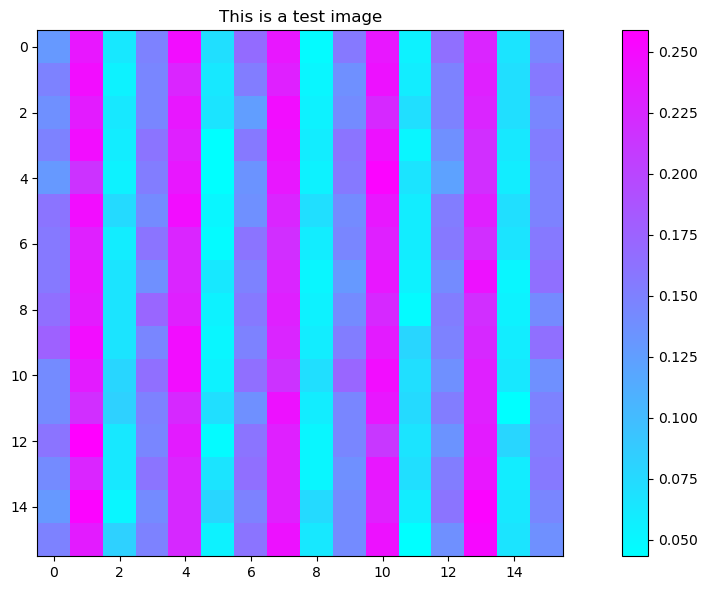

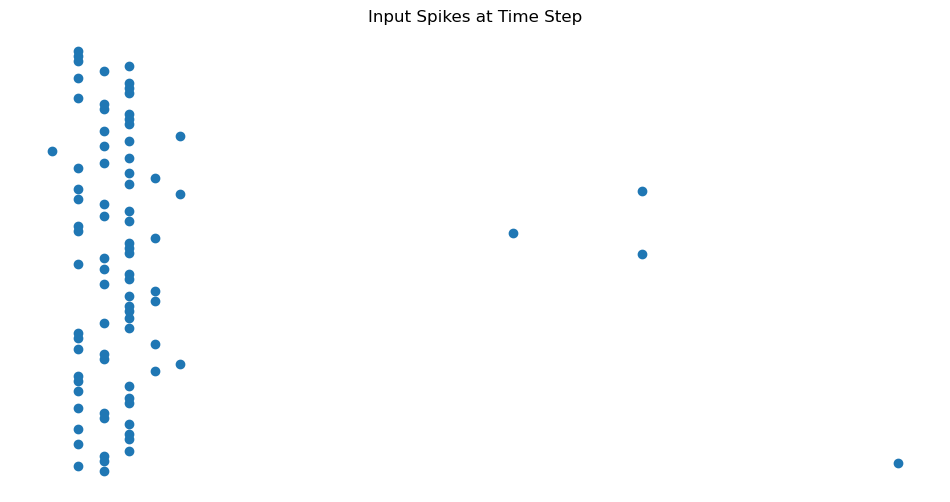

(50, 1, 2)


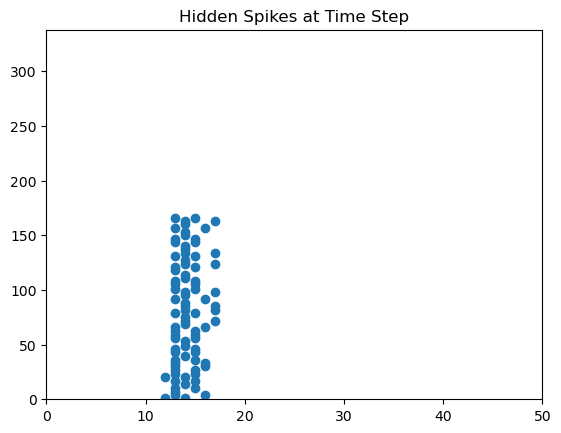

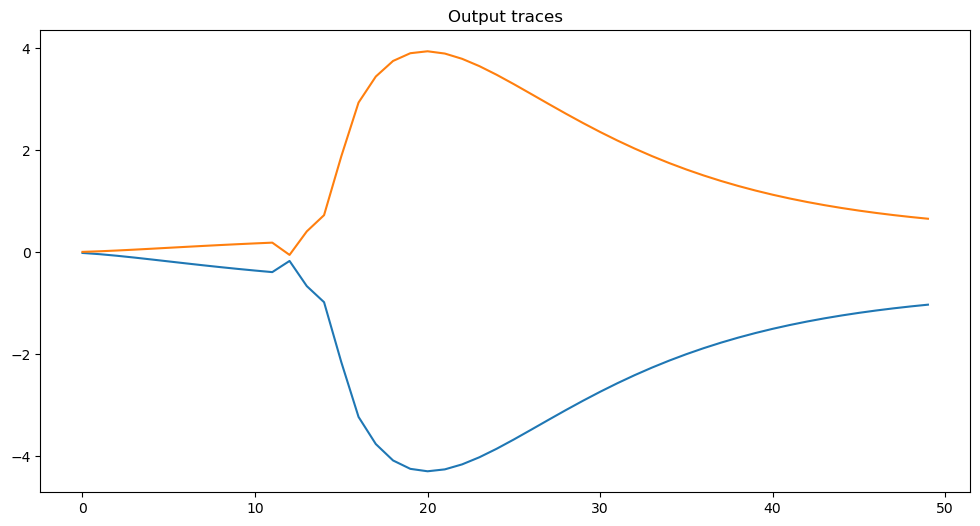

In [ ]:
model_plots(model=model, dataset=test_dataset, img_idx=10)

torch.Size([1, 16, 16])
torch.Size([1, 1, 16, 16])


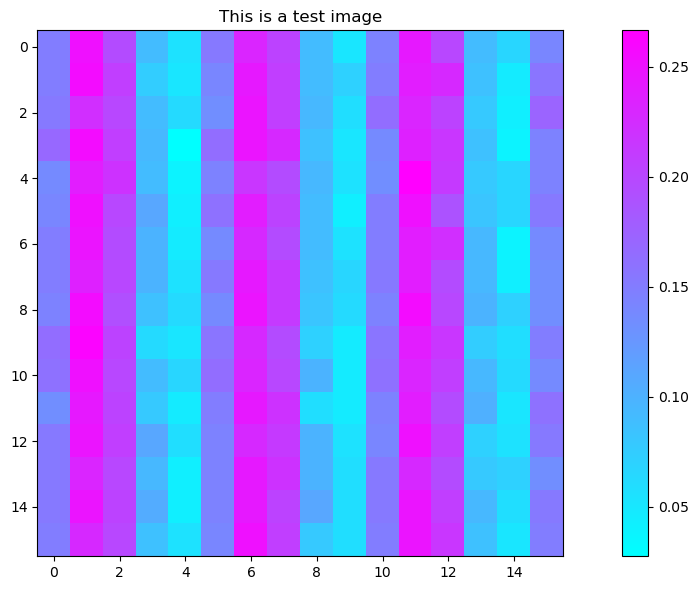

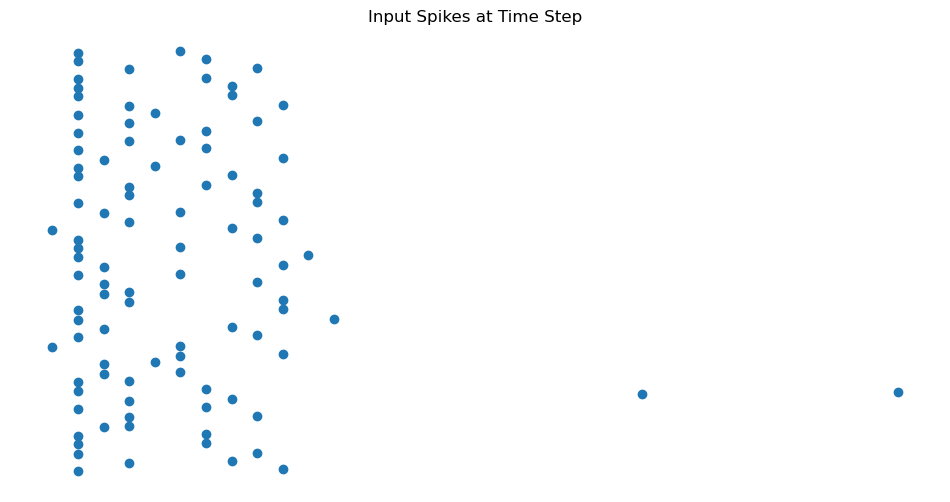

(50, 1, 2)


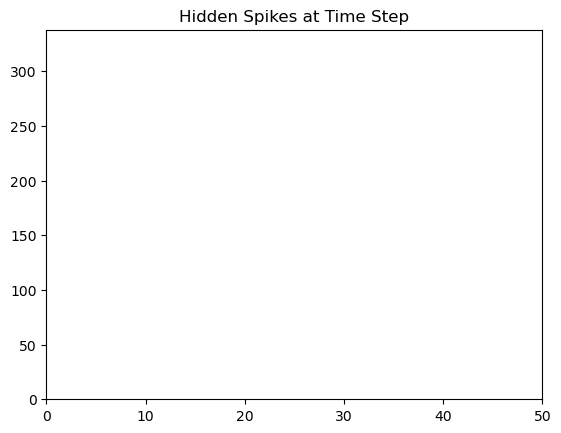

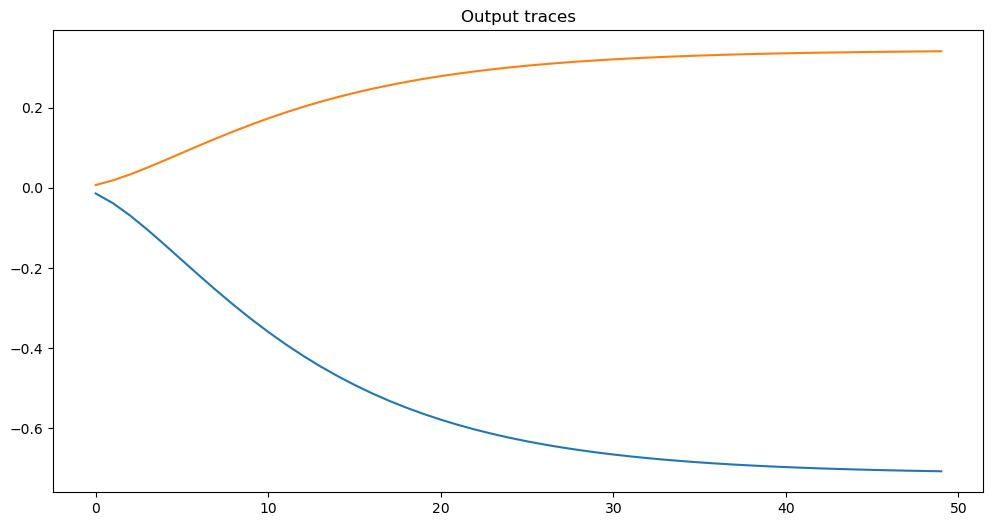

In [ ]:
model_plots(model=model, dataset=test_dataset, img_idx=34)

torch.Size([1, 16, 16])
torch.Size([1, 1, 16, 16])


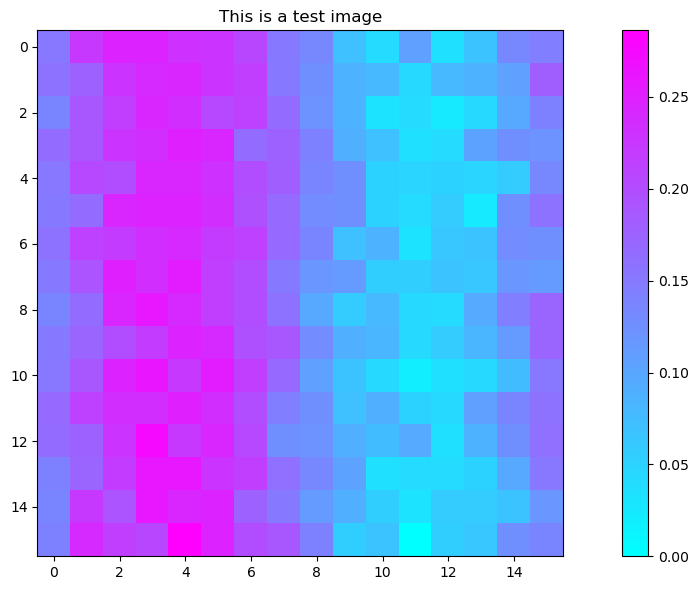

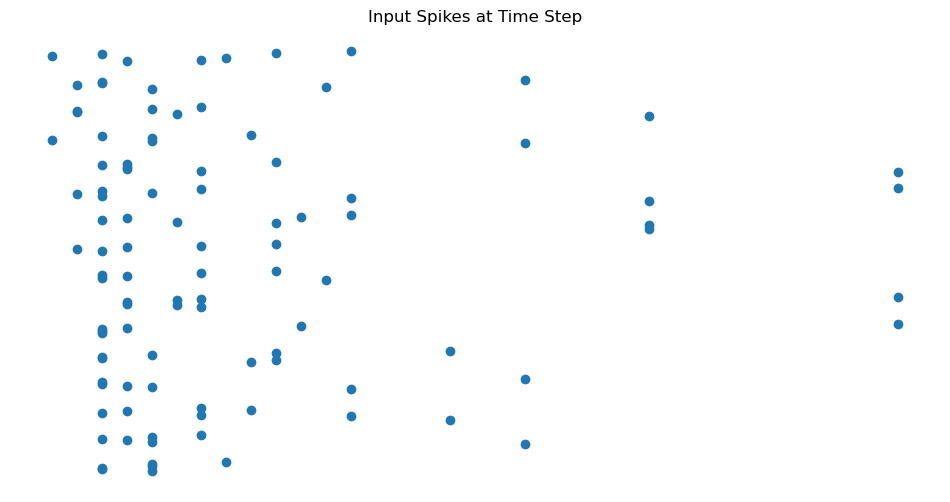

(50, 1, 2)


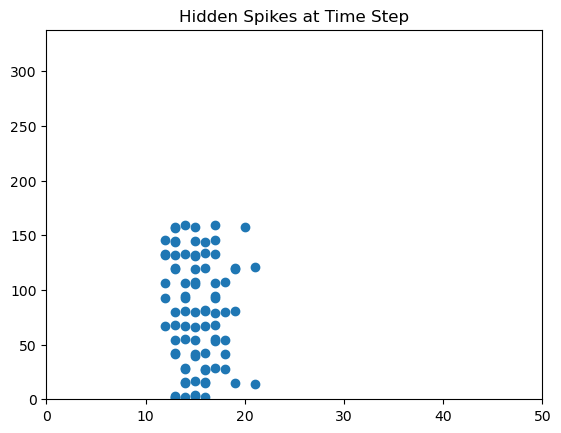

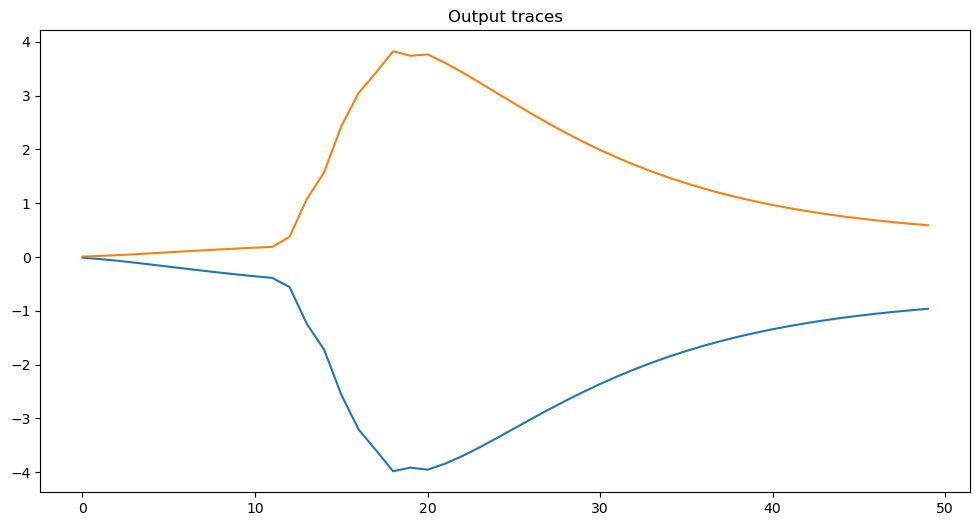

In [ ]:
model_plots(model=model, dataset=test_dataset, img_idx=32)

torch.Size([1, 16, 16])
torch.Size([1, 1, 16, 16])


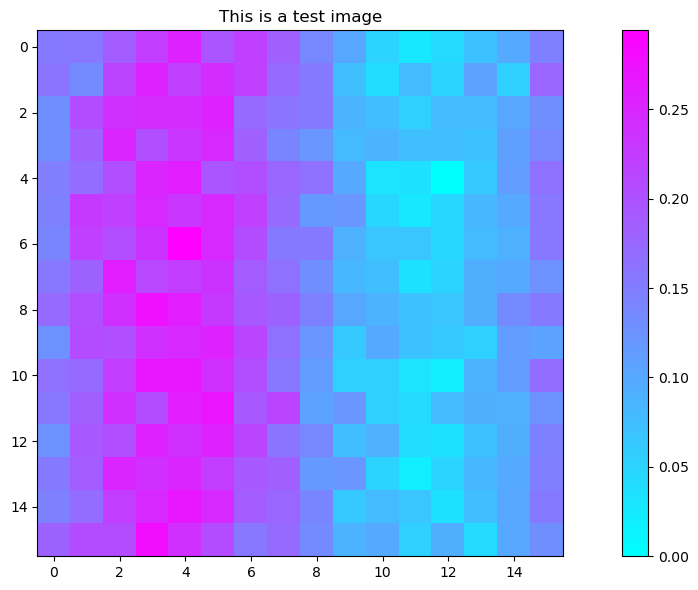

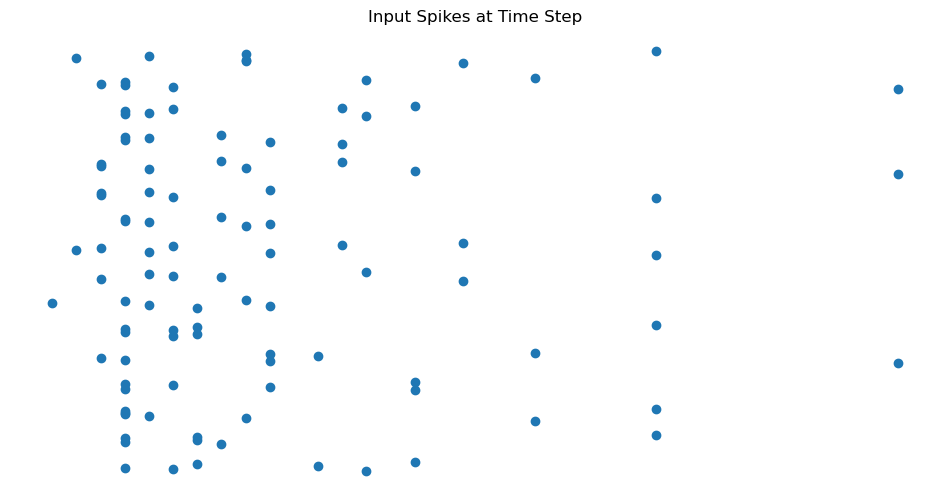

(50, 1, 2)


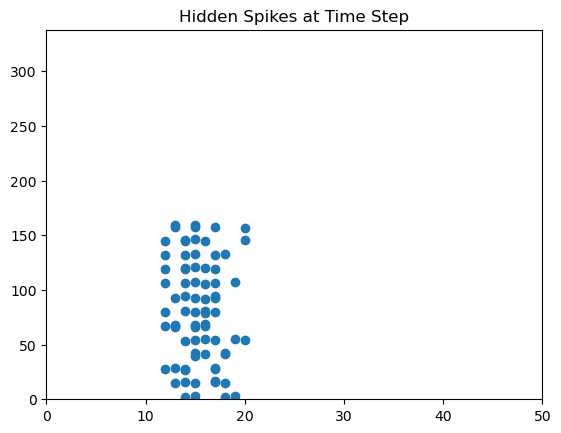

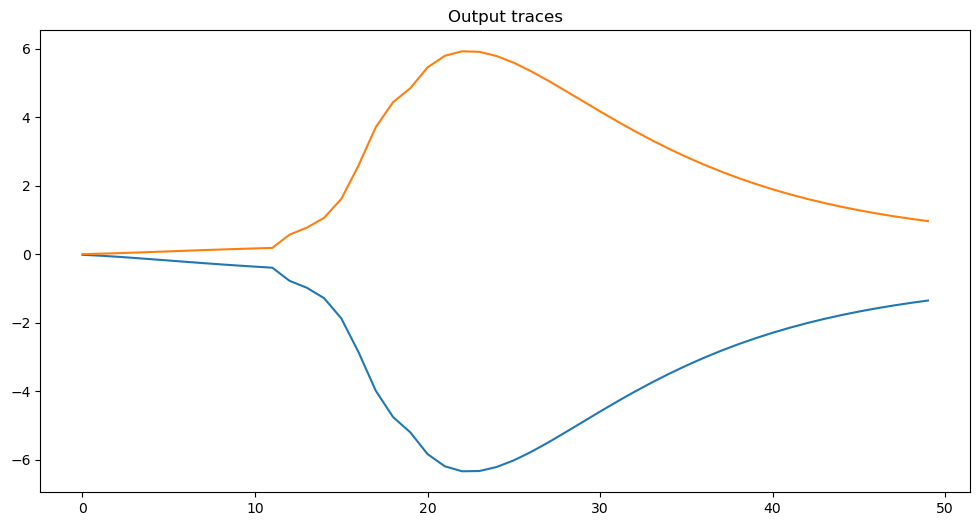

In [ ]:
model_plots(model=model, dataset=test_dataset, img_idx=2)

torch.Size([1, 16, 16])
torch.Size([1, 1, 16, 16])


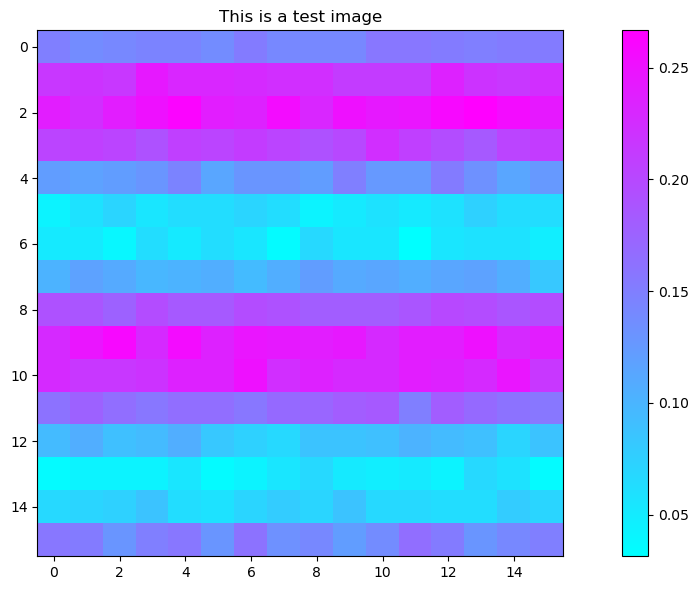

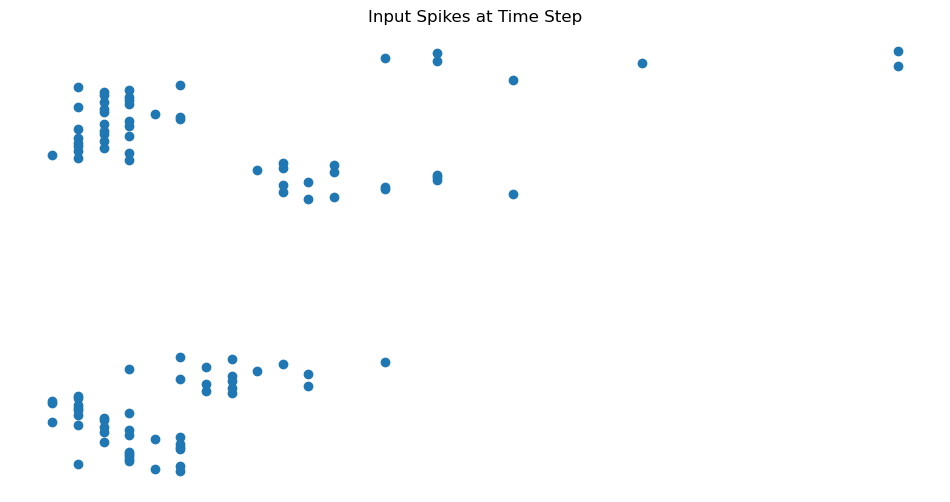

(50, 1, 2)


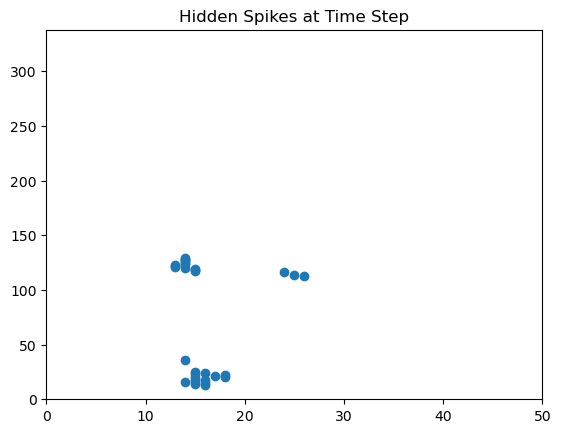

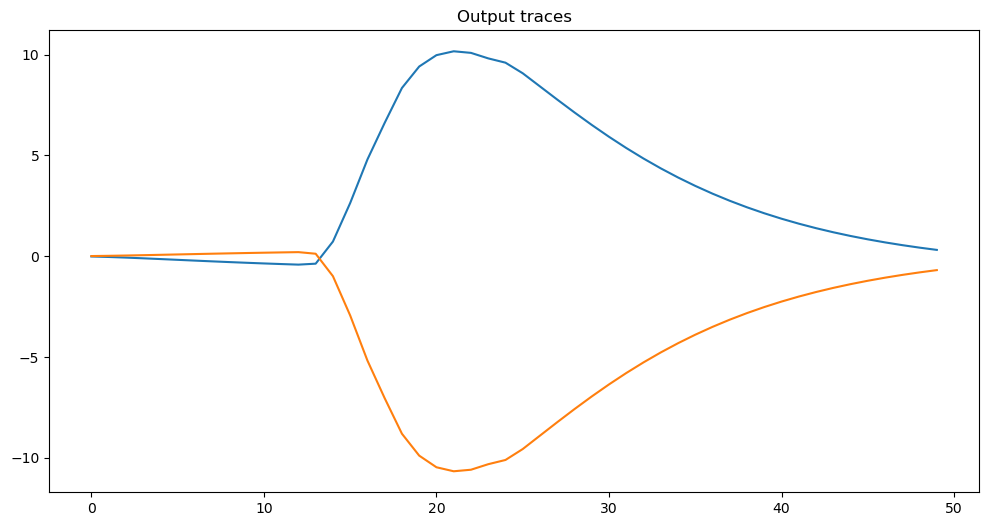

In [ ]:
model_plots(model=model, dataset=test_dataset, img_idx=1)